# Analysis

Read data files from multiple chillers and create a model

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import RidgeCV
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import Lasso
from sklearn                 import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

import pickle

%matplotlib inline

import re
import glob


# import custome utility functions
from util import plot_curves
from util import get_Xy
from util import compute_lift_lines

## LASSO

In [43]:
lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X_train,y_train)

0.8514419710277483

In [44]:
#alpha_list = [1e-4, 1e-3, 1e-2, .05, 1e-1,.3,.5,.7]
#alpha_list = [5e-6, 1e-5, 5e-5, 1e-4,5e-4,1e-3]
alpha_list = [1e-5, 5e-5, 1e-4,5e-4]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X_train, y_train)

    score = lr_lasso.score(X_train,y_train)
    RMSE = sqrt(mean_squared_error(y2_test, lr_lasso.predict(X2_test)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


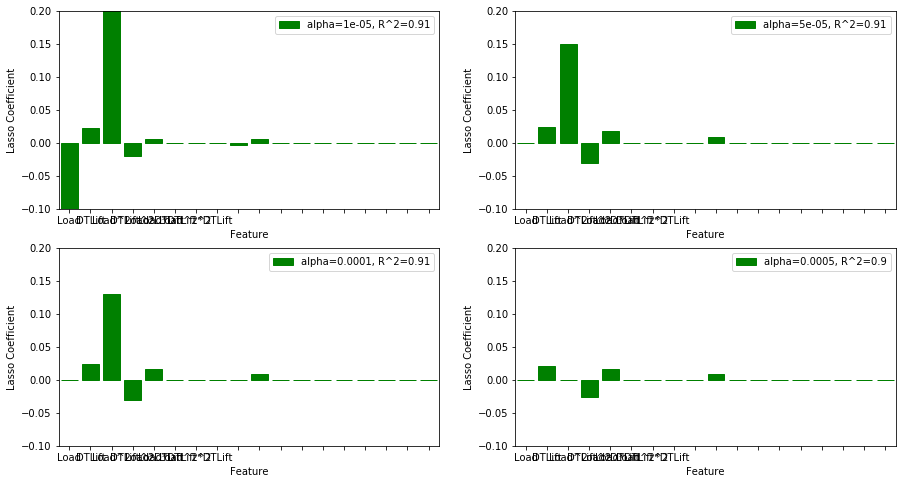

In [59]:
num_features = X_train.shape[1]

p = 0
num_plots = len(lasso_results)
fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*4))

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    plt.setp(axes, xticks=np.linspace(0,num_features+1, num=num_features+2), 
             xticklabels=['','Load','DTLift','Load^2','DTLift^2',
                          'Load*DTLift','Load*DTLift^2','Load^2*DTLift'],
             ylim=(-.1,.2),
             xlim=(0.5,num_features+.5))

    if test:
        axes[p//2,p%2].bar(range(1,num_features+1),coef,
                           label=f"alpha={alpha}, R^2={score:.2g}",
                           color='green',edgecolor='green')
        axes[p//2,p%2].set_xlabel("Feature")
        axes[p//2,p%2].set_ylabel("Lasso Coefficient")
        axes[p//2,p%2].legend()

        p +=1
        
if num_plots%2 == 1:
    axes[num_plots//2, 1].remove()  # don't display empty plot

plt.show()

In [61]:
X_train.columns

Index(['Load', 'DTLift', 'Load^2', 'Load*DTLift', 'Load^2*DTLift',
       'CompSH_mean', 'CompSH_std', 'CompSH_median', 'EvapApproach_mean',
       'EvapApproach_std', 'EvapApproach_median', 'CondApproach_mean',
       'CondApproach_std', 'CondApproach_median', 'REFLVL_mean', 'REFLVL_std',
       'REFLVL_median', 'RatedTon'],
      dtype='object')

## Read in all data files and chiller characteristics

In [2]:
PlantToModel = pd.read_csv('data/Chiller_Characteristics/PlantToModel.csv')
PlantToModel.set_index('Plant',inplace=True)
ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')
#ModelCharacteristics.set_index('ModelNo',inplace=True)

In [3]:
df_all = pd.DataFrame()

for file in glob.glob('data/*chiller.csv'):
    foo = re.match('data/(\d*[A-Z]+)(\d+)_chiller.csv',file)
    if foo is None:
        raise AttributeError(f'could not match {file}')

    PlantCode = foo.group(1)
    ChCode = foo.group(2)
    
    print(f'opening file: {file}        plant code: {PlantCode}        chiller code: {ChCode}')
    
    df = pd.read_csv(file)
    ModelNo = PlantToModel.loc[PlantCode+ChCode]['Model']
    df['ModelNo'] = ModelNo
    df['Chiller'] = PlantCode+ChCode
    
    df = pd.merge(df, ModelCharacteristics, on='ModelNo')
    df_all = df_all.append(df)


opening file: data/5T14_chiller.csv        plant code: 5T        chiller code: 14
opening file: data/S3_chiller.csv        plant code: S        chiller code: 3
opening file: data/1T8_chiller.csv        plant code: 1T        chiller code: 8
opening file: data/1T12_chiller.csv        plant code: 1T        chiller code: 12
opening file: data/1T1_chiller.csv        plant code: 1T        chiller code: 1
opening file: data/B2_chiller.csv        plant code: B        chiller code: 2
opening file: data/BC1_chiller.csv        plant code: BC        chiller code: 1
opening file: data/5T18_chiller.csv        plant code: 5T        chiller code: 18
opening file: data/1T4_chiller.csv        plant code: 1T        chiller code: 4
opening file: data/C2_chiller.csv        plant code: C        chiller code: 2
opening file: data/5T20_chiller.csv        plant code: 5T        chiller code: 20
opening file: data/C1_chiller.csv        plant code: C        chiller code: 1
opening file: data/1T7_chiller.csv      

In [5]:
data_file = 'data/ALL_chillers.csv'

In [6]:
df_all.to_csv(data_file)

In [7]:
def new_get_Xy(file_name,features=[]):
    df = pd.read_csv(file_name)

    if 'ModelNo' not in df.columns:
        print('getting model info')
        
        foo = re.match('data/(\d*[A-Z]+)(\d+)_chiller.csv',file_name)
        if foo is None:
            raise AttributeError(f'could not match {file_name}')

        PlantCode = foo.group(1)
        ChCode = foo.group(2)

        print(f'opening file: {file_name}        plant code: {PlantCode}        chiller code: {ChCode}')

        PlantToModel = pd.read_csv('data/Chiller_Characteristics/PlantToModel.csv')
        PlantToModel.set_index('Plant',inplace=True)
        ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')

        ModelNo = PlantToModel.loc[PlantCode+ChCode]['Model']
        df['ModelNo'] = ModelNo
        df['Chiller'] = PlantCode+ChCode

        df = pd.merge(df, ModelCharacteristics, on='ModelNo')    

    # remove rows with NaN on primary features
    num_rows = df.shape[0]
    df.dropna(subset=['Load','DTLift','kW/Ton'],inplace=True)
    print('DataFrame rows with NaN removed: ',num_rows - df.shape[0])

    y = df['kW/Ton'].copy()
    X = df[['Load','DTLift']].copy()

    if 'HigherOrder' in features:
        X['Load^2']        = df['Load']**2
        X['Load*DTLift']   = df['Load']*df['DTLift']
        X['Load^2*DTLift'] = (df['Load']**2)*df['DTLift']
    if 'ModelInfo' in features:  
        X['RatedTons']  = df['RatedTons']
        X['VarSpeed']   = df['VarSpeed']
        X['RatedkW']    = df['RatedkW']
        X['CDesFlow']   = df['CDesFlow']
        X['CPDrop']     = df['CPDrop']
        X['CEnterTemp'] = df['CEnterTemp']
        X['CLeaveTemp'] = df['CLeaveTemp']
        X['EDesFlow']   = df['EDesFlow']
        X['EPDrop']     = df['EPDrop']
        X['EEnterTemp'] = df['EEnterTemp']
        X['ELeaveTemp'] = df['ELeaveTemp']

    return X, y, df

In [9]:
data_file = 'data/ALL_chillers.csv'
feat = ['HigherOrder','ModelInfo']

X, y, df = new_get_Xy(data_file,feat)

print(X.shape)
print(X.dropna().shape)

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

DataFrame rows with NaN removed:  54485
(942132, 16)
(942132, 16)
(565279, 16) (565279,)
(376853, 16) (376853,)


In [10]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

6.386925452803087
[-4.15301300e-01  2.26546070e-02  5.32403773e-01 -2.14191572e-02
  5.21034489e-03 -1.29299151e-02  1.76520803e-02  4.27079672e-03
  3.81652128e-03 -2.01848712e-02 -6.70016688e-02 -7.41647860e-02
 -2.89079351e-04  2.52928436e-03  3.10495467e-02  1.06893820e-01]


In [11]:
print('train: ',lr.score(X_train,y_train))
print('test : ',lr.score(X_test,y_test))

train:  0.9075376015235922
test :  0.908050362358404


In [14]:
def Ch_Results(Chiller,feat,lr):

    data_file = 'data/'+Chiller+'_chiller.csv'
    X_test, y_test, df = new_get_Xy(data_file,feat)
    print(Chiller+':',X_train.shape,y_train.shape)
    print('R^2: ',lr.score(X_test,y_test))
    
    lift_lines = compute_lift_lines(lr, feat, df, RatedTon, plot=False)
    plot_curves(df,lift_lines,'Chiller '+Chiller)



## BCBS

getting model info
opening file: data/B1_chiller.csv        plant code: B        chiller code: 1
DataFrame rows with NaN removed:  148
B1: (565279, 16) (565279,)
R^2:  0.9049464228033636


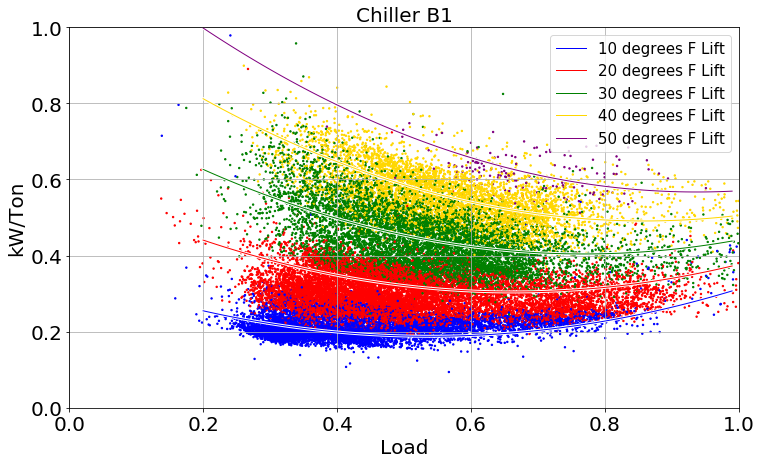

getting model info
opening file: data/B2_chiller.csv        plant code: B        chiller code: 2
DataFrame rows with NaN removed:  200
B2: (565279, 16) (565279,)
R^2:  0.8291246479000121


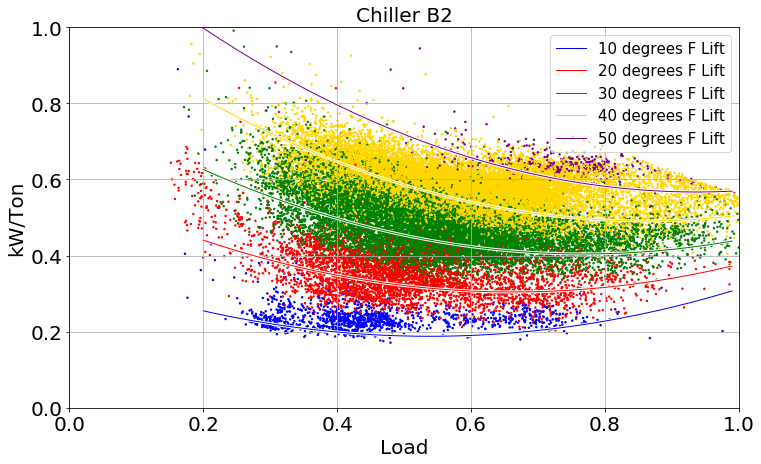

getting model info
opening file: data/B3_chiller.csv        plant code: B        chiller code: 3
DataFrame rows with NaN removed:  101
B3: (565279, 16) (565279,)
R^2:  0.9220753255633836


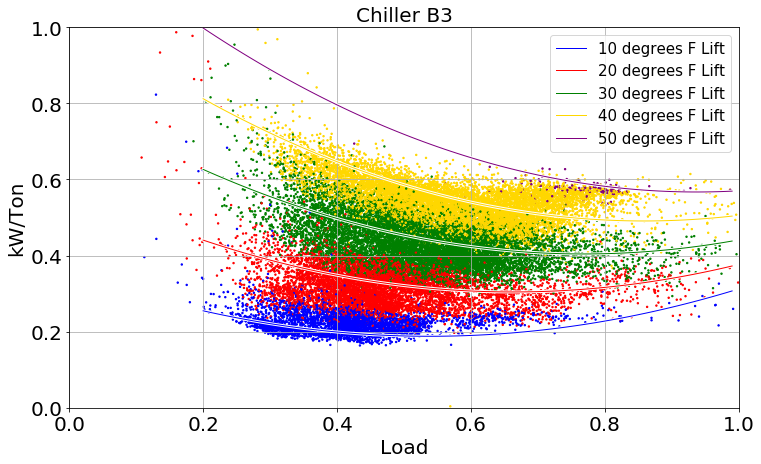

getting model info
opening file: data/B4_chiller.csv        plant code: B        chiller code: 4
DataFrame rows with NaN removed:  2
B4: (565279, 16) (565279,)
R^2:  0.6975487367392154


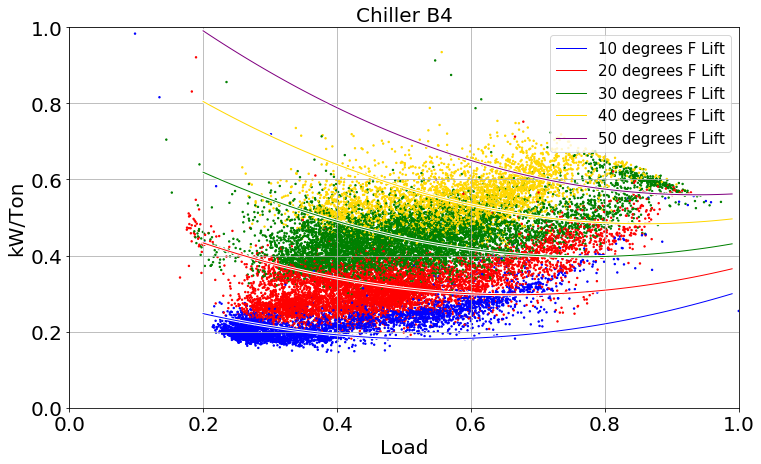

In [15]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 900
    
PlantCode = 'B'
Chillers = ['1','2','3','4']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,lr)


## Tabreed BD01

getting model info
opening file: data/1T1_chiller.csv        plant code: 1T        chiller code: 1
DataFrame rows with NaN removed:  3
1T1: (565279, 16) (565279,)
R^2:  0.5469375670553164


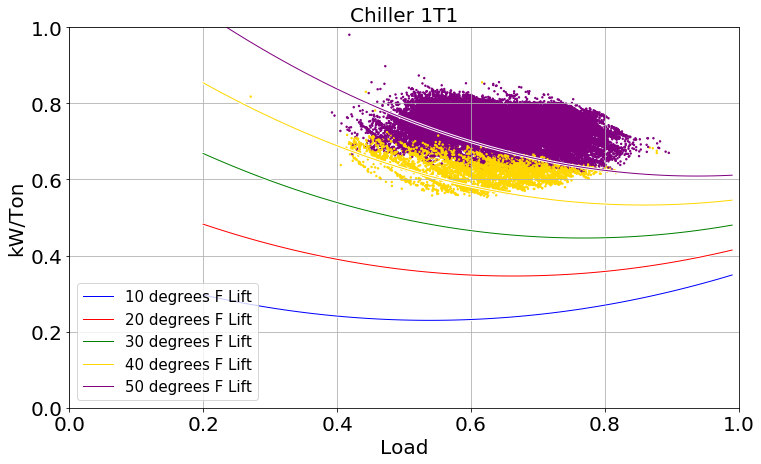

getting model info
opening file: data/1T3_chiller.csv        plant code: 1T        chiller code: 3
DataFrame rows with NaN removed:  0
1T3: (565279, 16) (565279,)
R^2:  0.798124789633665


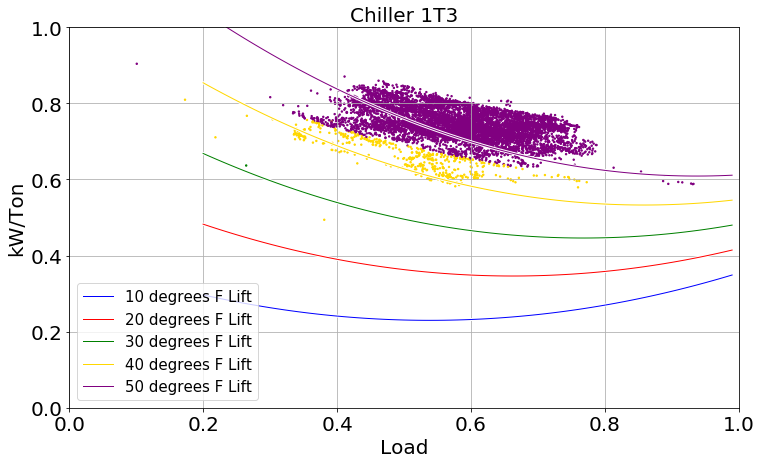

getting model info
opening file: data/1T4_chiller.csv        plant code: 1T        chiller code: 4
DataFrame rows with NaN removed:  0
1T4: (565279, 16) (565279,)
R^2:  -2.0582245051946573


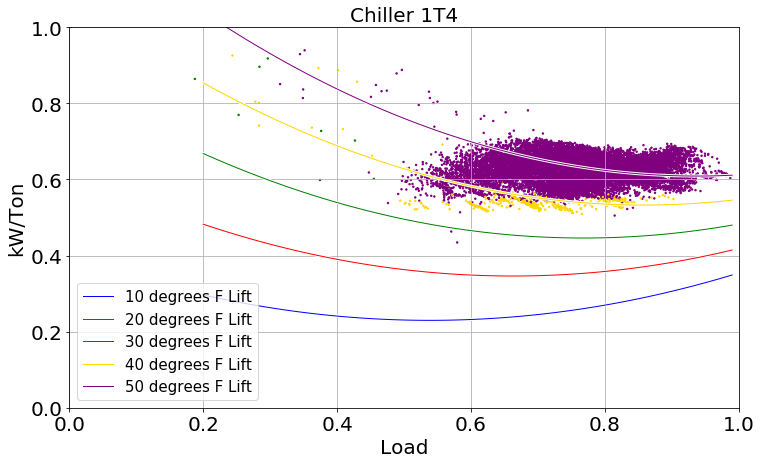

getting model info
opening file: data/1T5_chiller.csv        plant code: 1T        chiller code: 5
DataFrame rows with NaN removed:  3
1T5: (565279, 16) (565279,)
R^2:  -5.351902951734126


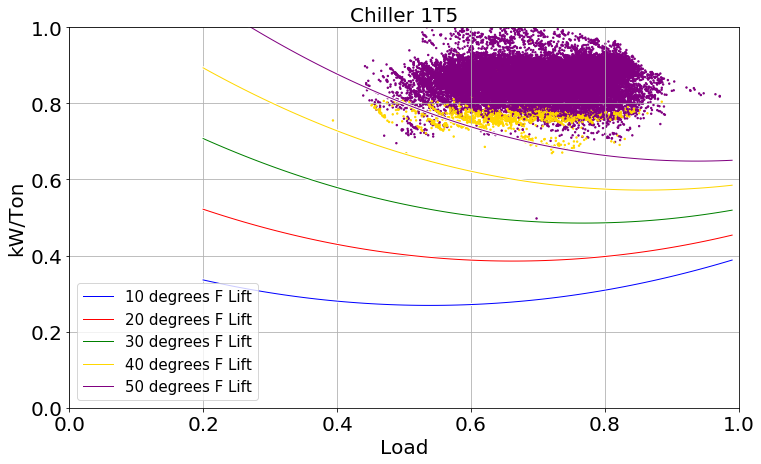

getting model info
opening file: data/1T6_chiller.csv        plant code: 1T        chiller code: 6
DataFrame rows with NaN removed:  17929
1T6: (565279, 16) (565279,)
R^2:  0.02087486212208467


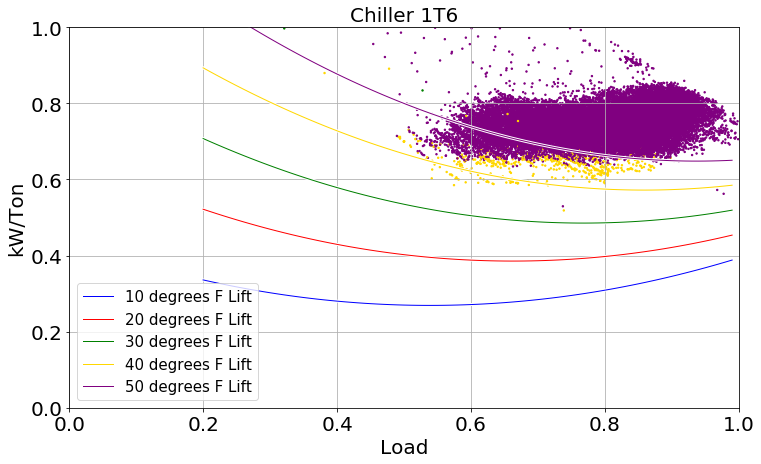

getting model info
opening file: data/1T7_chiller.csv        plant code: 1T        chiller code: 7
DataFrame rows with NaN removed:  58
1T7: (565279, 16) (565279,)
R^2:  0.7975928061335569


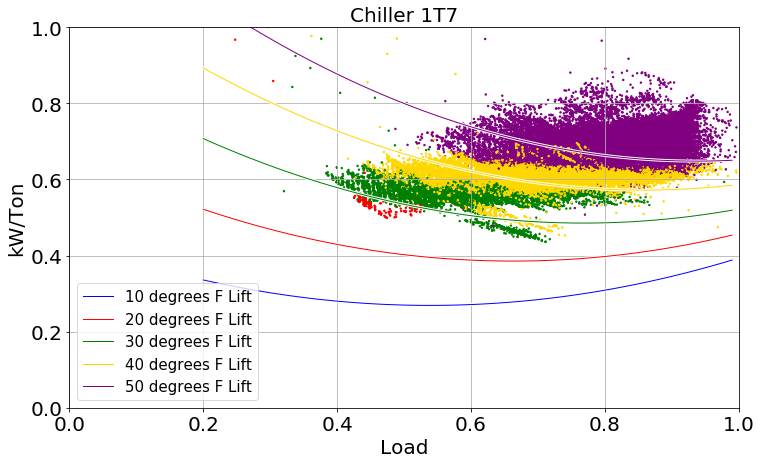

getting model info
opening file: data/1T8_chiller.csv        plant code: 1T        chiller code: 8
DataFrame rows with NaN removed:  39
1T8: (565279, 16) (565279,)
R^2:  0.6211069986724669


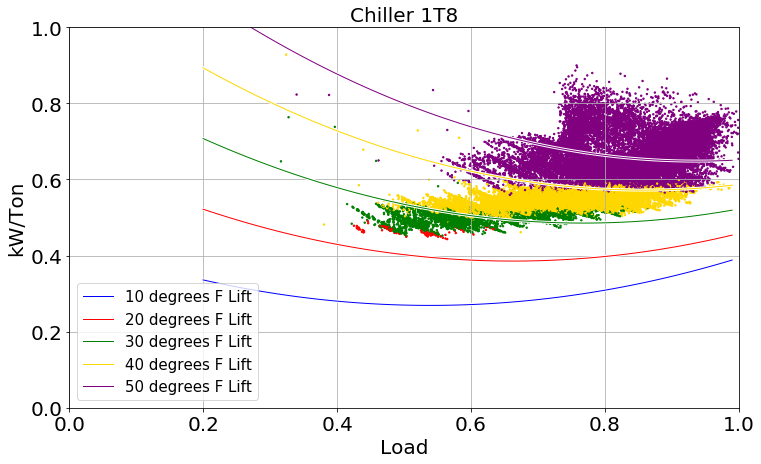

getting model info
opening file: data/1T9_chiller.csv        plant code: 1T        chiller code: 9
DataFrame rows with NaN removed:  20
1T9: (565279, 16) (565279,)
R^2:  0.628586892194779


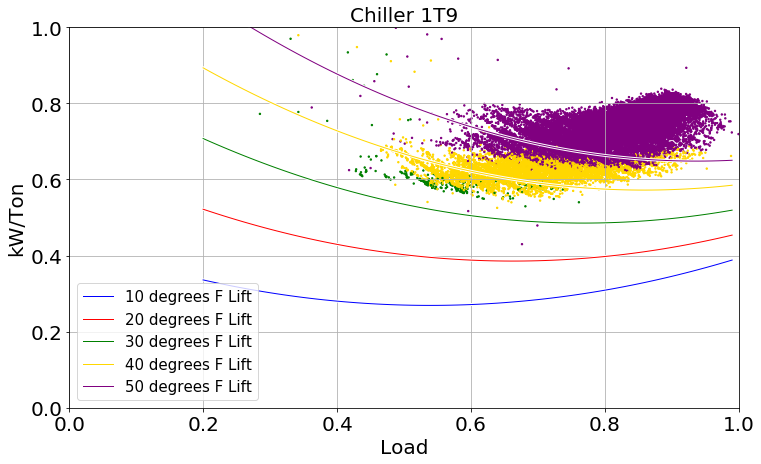

getting model info
opening file: data/1T10_chiller.csv        plant code: 1T        chiller code: 10
DataFrame rows with NaN removed:  7
1T10: (565279, 16) (565279,)
R^2:  0.3422441732302076


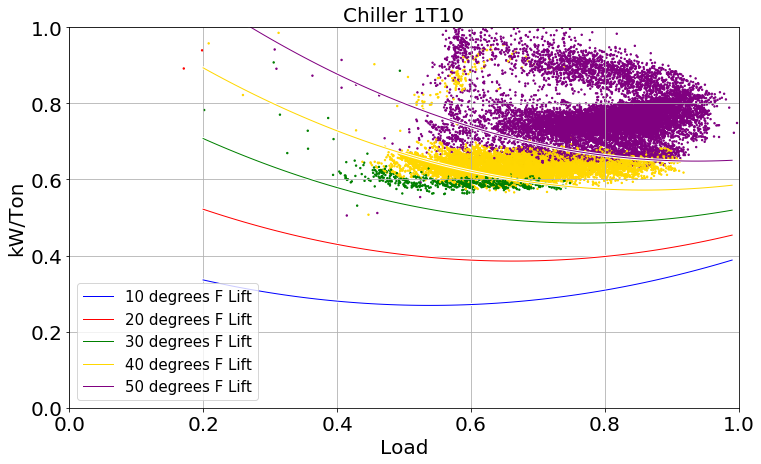

getting model info
opening file: data/1T11_chiller.csv        plant code: 1T        chiller code: 11
DataFrame rows with NaN removed:  23
1T11: (565279, 16) (565279,)
R^2:  0.584597549285228


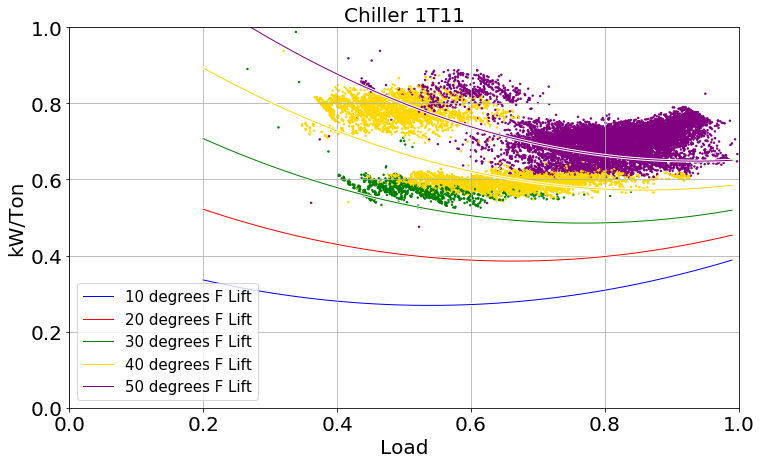

getting model info
opening file: data/1T12_chiller.csv        plant code: 1T        chiller code: 12
DataFrame rows with NaN removed:  30
1T12: (565279, 16) (565279,)
R^2:  -0.4625143706571653


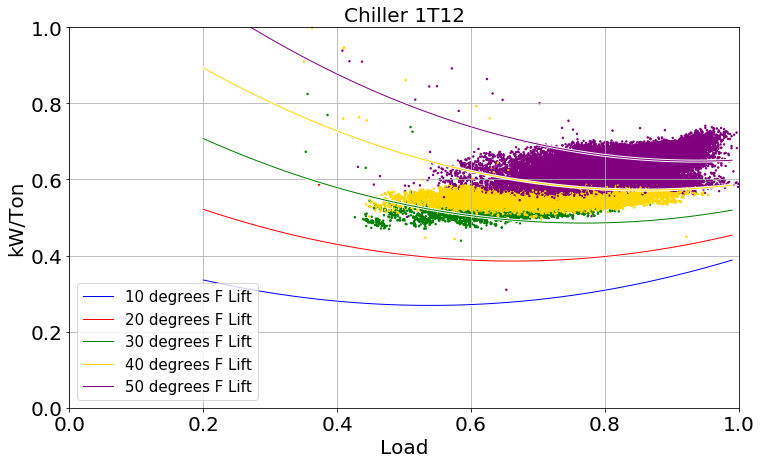

In [16]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 1850
    
PlantCode = '1T'
Chillers = ['1','3','4']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,lr)

RatedTon = 1850
PlantCode = '1T'
Chillers = ['5','6','7','8','9','10','11','12']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,lr)


## Samford

getting model info
opening file: data/S1_chiller.csv        plant code: S        chiller code: 1
DataFrame rows with NaN removed:  3
S1: (14272, 18) (14272,)
R^2:  0.8674720231162037


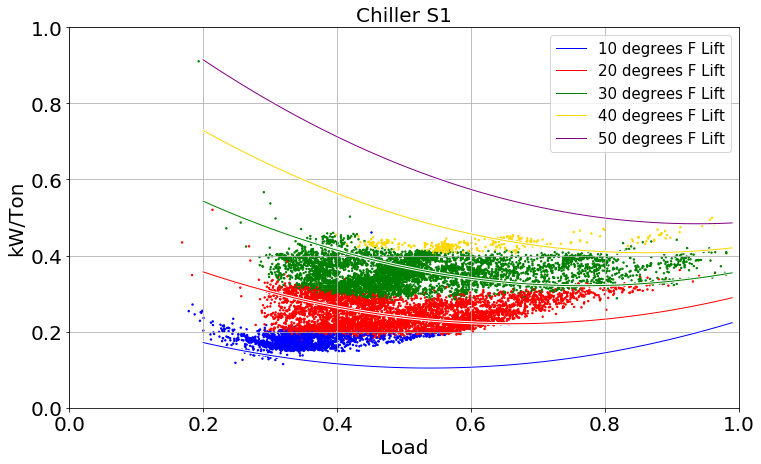

getting model info
opening file: data/S3_chiller.csv        plant code: S        chiller code: 3
DataFrame rows with NaN removed:  7
S3: (14272, 18) (14272,)
R^2:  0.8102830375549078


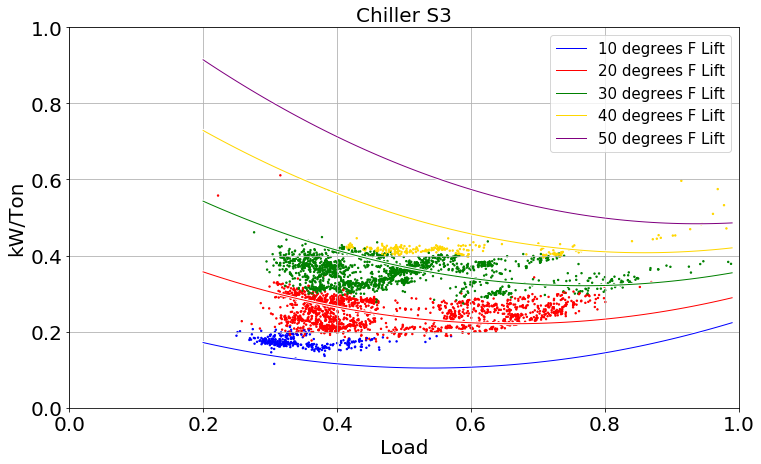

getting model info
opening file: data/S4_chiller.csv        plant code: S        chiller code: 4
DataFrame rows with NaN removed:  8
S4: (14272, 18) (14272,)
R^2:  0.9050715325374774


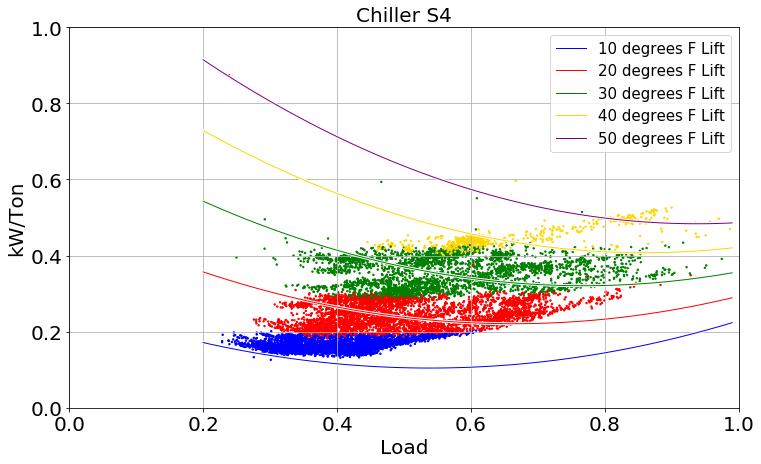

In [18]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 1500
    
PlantCode = 'S'
Chillers = ['1','3','4']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,lr)

In [ ]:
pickle.dump(lift_lines,open('lift_lines.pkl','wb'))

## BCBS

CH1 YKKJKLH9-CWF 900 Tons   
CH2 YKKJKLH9-CWF 900 Tons   
CH3 YKKJKLH9-CWF 900 Tons   
CH4 YKKCKSH9-CWG 900 Tons   

getting model info
opening file: data/B1_chiller.csv        plant code: B        chiller code: 1
DataFrame rows with NaN removed:  148
B1: (14272, 18) (14272,)
R^2:  0.9049464228033636


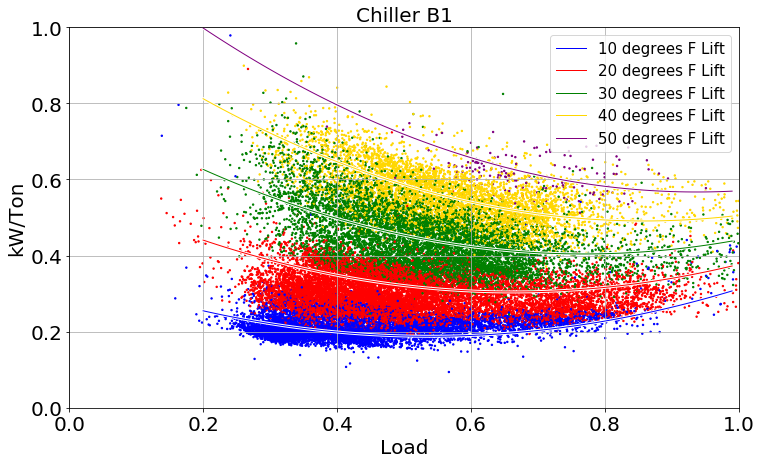

getting model info
opening file: data/B2_chiller.csv        plant code: B        chiller code: 2
DataFrame rows with NaN removed:  200
B2: (14272, 18) (14272,)
R^2:  0.8291246479000121


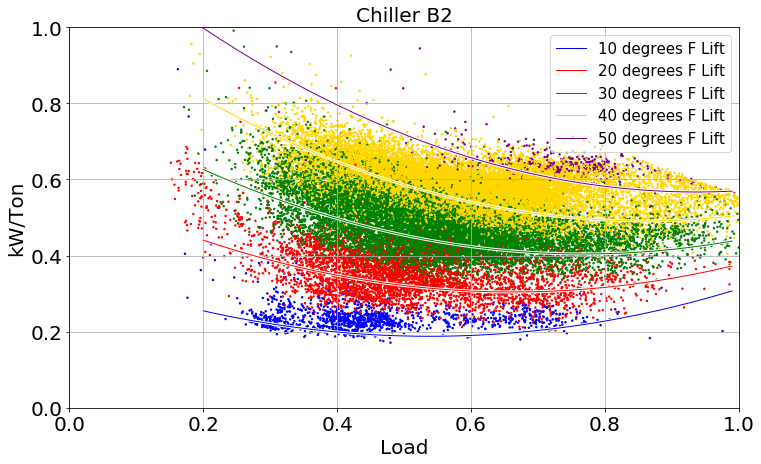

getting model info
opening file: data/B3_chiller.csv        plant code: B        chiller code: 3
DataFrame rows with NaN removed:  101
B3: (14272, 18) (14272,)
R^2:  0.9220753255633836


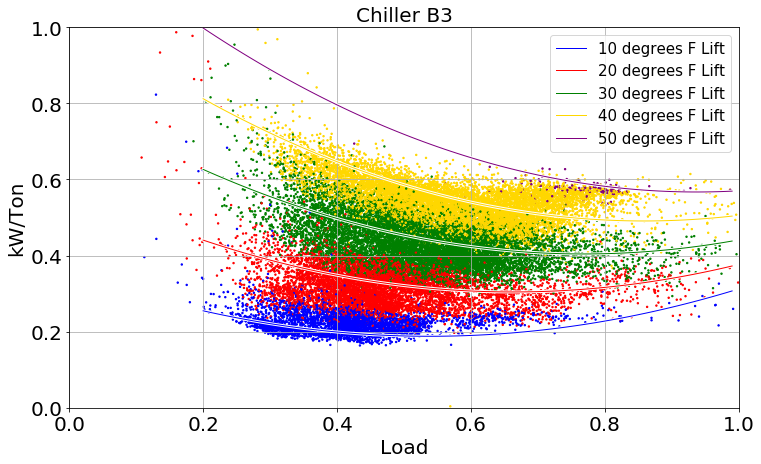

getting model info
opening file: data/B4_chiller.csv        plant code: B        chiller code: 4
DataFrame rows with NaN removed:  2
B4: (14272, 18) (14272,)
R^2:  0.6975487367392154


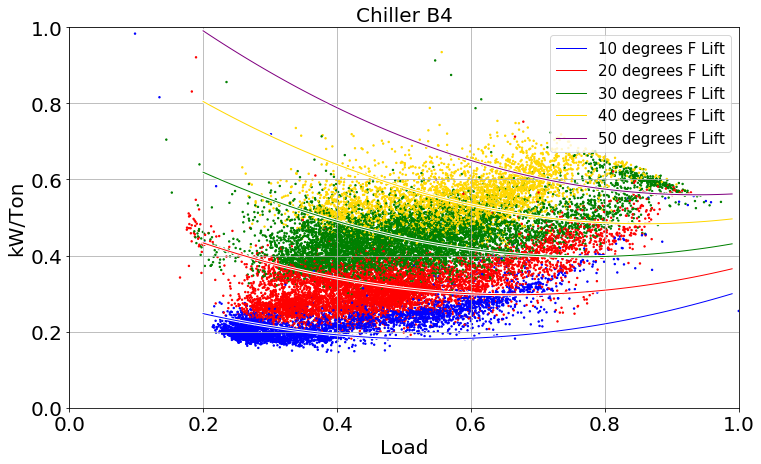

In [20]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 900
    
PlantCode = 'B'
Chillers = ['1','2','3','4']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,lr)

## CMH

getting model info
opening file: data/C1_chiller.csv        plant code: C        chiller code: 1
DataFrame rows with NaN removed:  1437
C1: (14272, 18) (14272,)
R^2:  0.8886399872614124


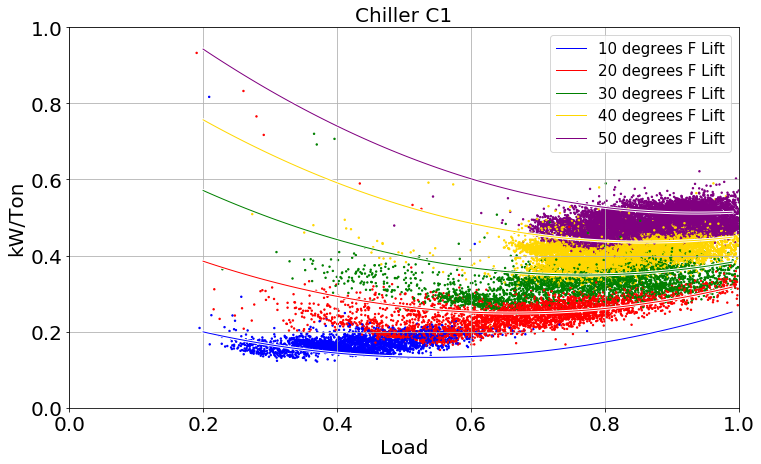

getting model info
opening file: data/C2_chiller.csv        plant code: C        chiller code: 2
DataFrame rows with NaN removed:  9879
C2: (14272, 18) (14272,)
R^2:  0.46445476382141715


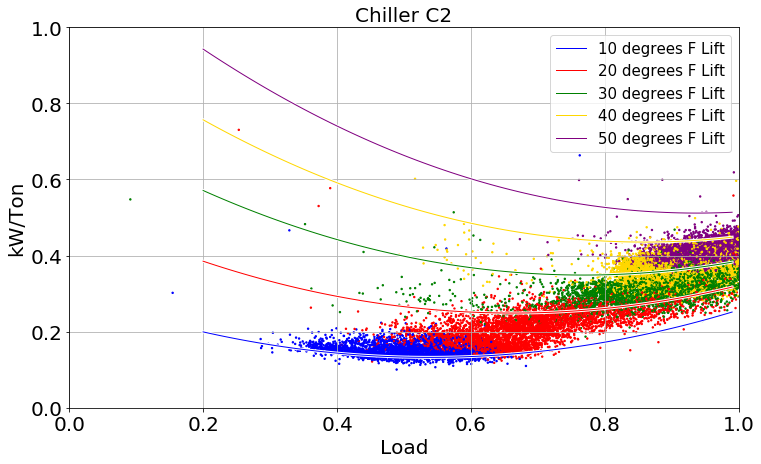

getting model info
opening file: data/C3_chiller.csv        plant code: C        chiller code: 3
DataFrame rows with NaN removed:  5067
C3: (14272, 18) (14272,)
R^2:  0.8605966039084466


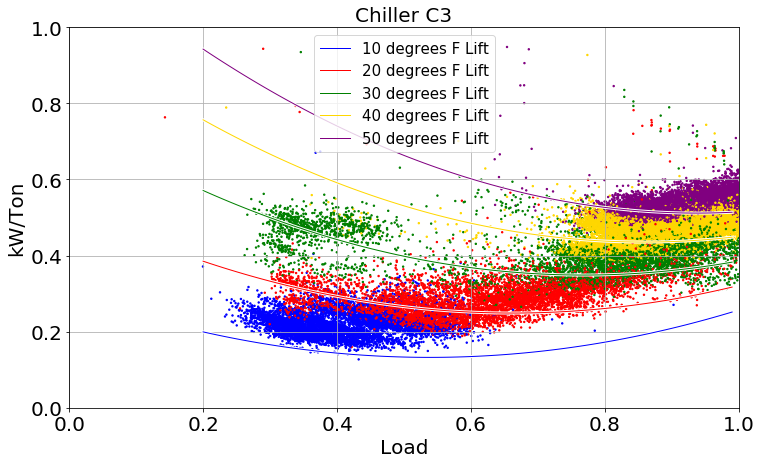

getting model info
opening file: data/C4_chiller.csv        plant code: C        chiller code: 4
DataFrame rows with NaN removed:  2128
C4: (14272, 18) (14272,)
R^2:  0.9149440529015977


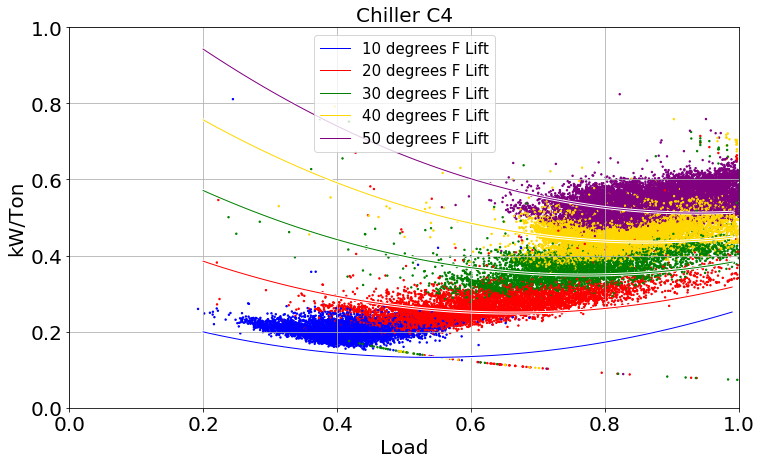

In [21]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 1200
    
PlantCode = 'C'
Chillers = ['1','2','3','4']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,lr)

## Tabreed DB05

getting model info
opening file: data/5T14_chiller.csv        plant code: 5T        chiller code: 14
DataFrame rows with NaN removed:  1058
5T14: (14272, 18) (14272,)
R^2:  0.29298712923949344


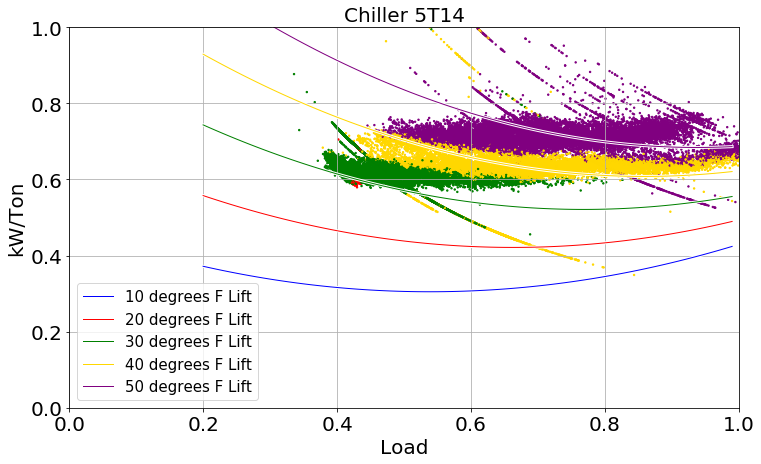

getting model info
opening file: data/5T16_chiller.csv        plant code: 5T        chiller code: 16
DataFrame rows with NaN removed:  235
5T16: (14272, 18) (14272,)
R^2:  -2.802235265410968


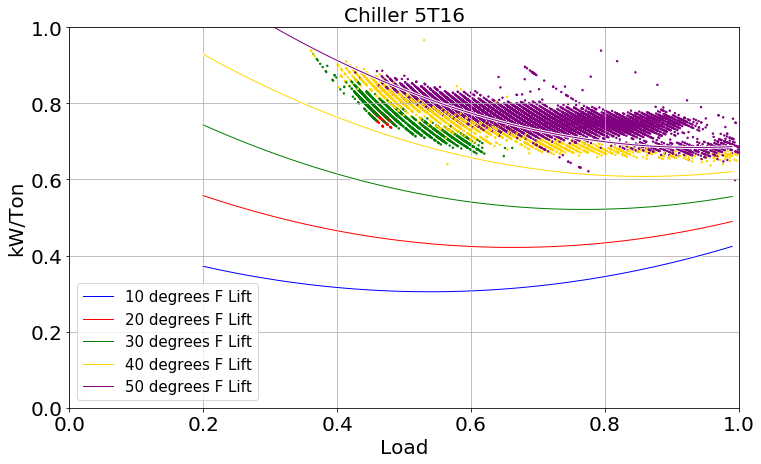

getting model info
opening file: data/5T18_chiller.csv        plant code: 5T        chiller code: 18
DataFrame rows with NaN removed:  639
5T18: (14272, 18) (14272,)
R^2:  0.13462385010639533


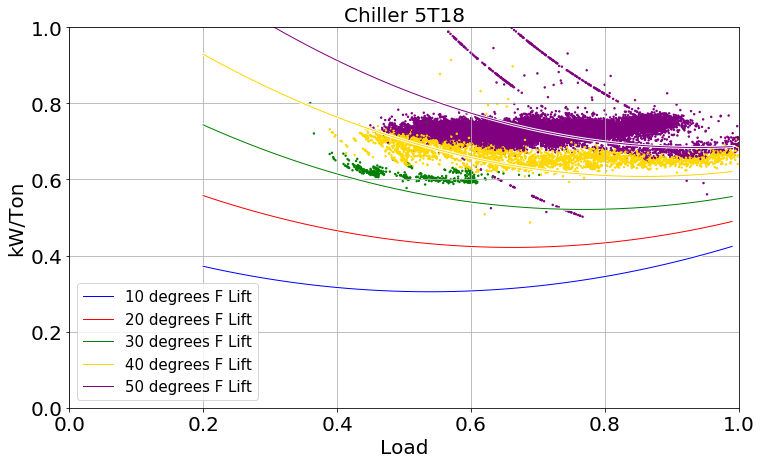

getting model info
opening file: data/5T20_chiller.csv        plant code: 5T        chiller code: 20
DataFrame rows with NaN removed:  189
5T20: (14272, 18) (14272,)
R^2:  0.2418530175995559


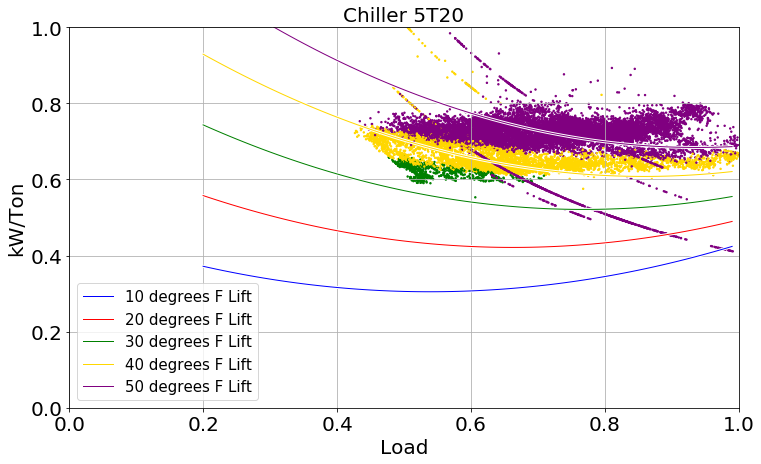

In [22]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 1875
    
PlantCode = '5T'
Chillers = ['14','16','18','20']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,lr)


## Bio Cork

getting model info
opening file: data/BC1_chiller.csv        plant code: BC        chiller code: 1
DataFrame rows with NaN removed:  5765
BC1: (14272, 18) (14272,)
R^2:  0.535369638366532


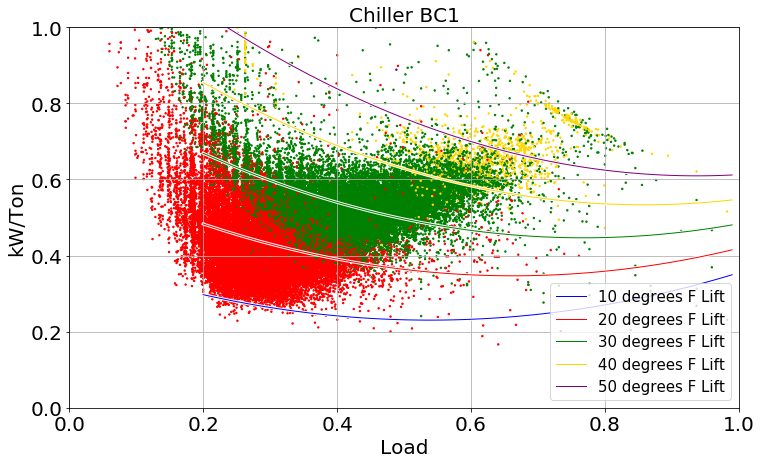

getting model info
opening file: data/BC2_chiller.csv        plant code: BC        chiller code: 2
DataFrame rows with NaN removed:  9491
BC2: (14272, 18) (14272,)
R^2:  0.6539106255924215


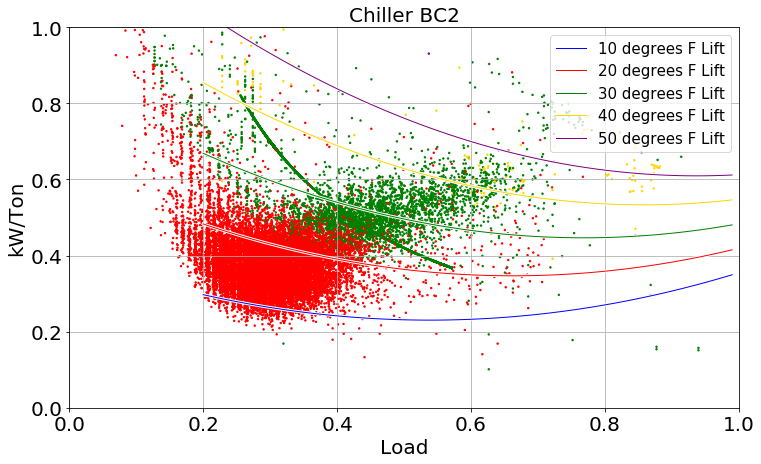

In [23]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 853
    
PlantCode = 'BC'
Chillers = ['1','2']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,lr)


## Things to try

Random Forest Regression